In [1]:
import matplotlib.pyplot as plt
import matplotlib.collections as mplc
import pysal as ps
from pysal.contrib import compact as com
from shapely import geometry as sgeom
import descartes as des
%matplotlib inline

In [2]:
data = ps.open(ps.examples.get_path('columbus.shp')).read()
chain = data[0]

In [3]:
points = [point for part in chain.parts for point in part]
points

[(9.391454696655273, 11.275400161743164),
 (9.546306610107422, 11.285369873046875),
 (9.5482759475708, 11.21343994140625),
 (9.656153678894043, 11.212479591369629),
 (9.776052474975586, 11.211409568786621),
 (9.779011726379395, 11.118490219116211),
 (9.774969100952148, 11.007590293884277),
 (9.775935173034668, 10.92866039276123),
 (9.78189754486084, 10.853730201721191),
 (9.095559120178223, 10.828829765319824),
 (9.10042953491211, 10.899089813232422),
 (9.135557174682617, 10.917750358581543),
 (9.146570205688477, 10.976699829101562),
 (9.178548812866211, 10.999670028686523),
 (9.175572395324707, 11.048629760742188),
 (9.282283782958984, 11.048029899597168),
 (9.393360137939453, 11.052599906921387),
 (9.39454460144043, 11.139530181884766),
 (9.3948974609375, 11.165470123291016),
 (9.393250465393066, 11.251399993896484),
 (9.39303207397461, 11.262740135192871),
 (9.391454696655273, 11.275400161743164)]

Let's plot that polygon by interpreting it in Shapely and using its draw behavior.

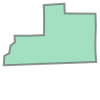

In [4]:
poly = sgeom.Polygon(points)
poly

Nifty. Now, I've implemented Skyum's method for finding the Minimum Bounding Circle for a set of points in `centrography`. 

Right now, there's some extra printing. Essentially, if you have sufficiently straight lines on the boundary, the equations for the circumcenter of the tuple $(p,q,r)$ explodes. Thus, I test if $\angle (p,q,r)$ identifies a circle whose diameter is $(p,r)$ or $(p,q)$. There are two triplets of straight enough lines, so their circle equations are modified, and I retain printing for bug diagnostics.

In [5]:
points = [points[i] for i in com.mbc.ConvexHull(points).vertices]

In [6]:
points.reverse()
com.mbc.not_clockwise(points)

False

In [7]:
angles = [com.mbc._angle(*com.mbc._neighb(p, points)) for p in points]

In [8]:
circles = [com.mbc._circle(*com.mbc._neighb(p, points)) for p in points]

In [9]:
radii = [c[0] for c in circles]

In [10]:
lexord = com.np.lexsort((radii, angles))
lexmax = lexord[-1]

In [11]:
print('index: ', lexmax)
print('angle: ', angles[lexmax])
print('radius: {} \t center: {}'.format(circles[lexmax][0], circles[lexmax][1]))
print('neighborhood: {}'.format(com.mbc._neighb(points[lexmax], points)))

('index: ', 5)
('angle: ', 3.1206552085296875)
radius: 8.5433838693 	 center: (1.2386039564668676, 10.893006157933069)
neighborhood: ((9.776052474975586, 11.211409568786621), (9.779011726379395, 11.118490219116211), (9.78189754486084, 10.853730201721191))


In [12]:
if not angles[lexmax] <= com.mbc.PI/2.:
    points.pop(lexmax)

In [13]:
radius, center = com.mbc.minimum_bounding_circle(points)
#p,q,r = cent.skyum(points)
#mbc = cent._circle(points[p], points[q], points[r])
#mbc = cent._circle()
mbc_poly = sgeom.Point(*center).buffer(radius)

In [14]:
radius, center

(0.39033271447063694, (9.435805797576904, 11.020119667053223))

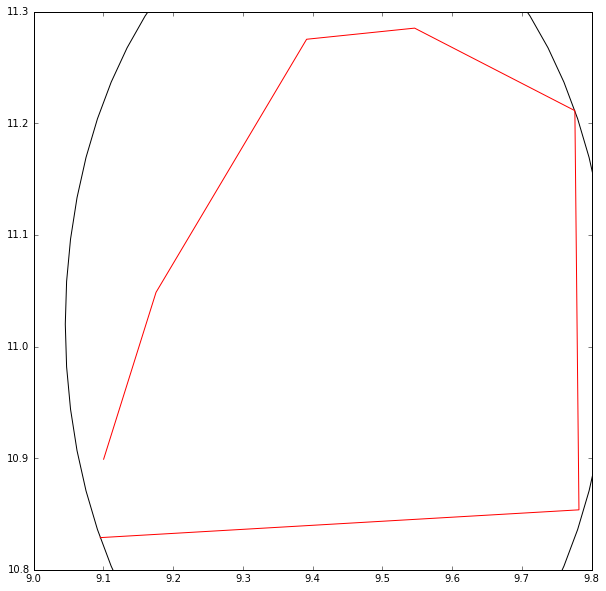

In [16]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot([p[0] for p in points], [p[-1] for p in points], 'r')
ax.add_patch(des.PolygonPatch(mbc_poly, fc='white', ec='black'))
plt.show()

### Cool. How fast is this?

In [17]:
import time

In [18]:
def demo_mbc(chains):
    for cidx, chain in enumerate(chains):
        points = chain
        start = time.time()
        (radius, center) = com.mbc.minimum_bounding_circle(chain)
        elapsed = time.time() - start
        mbc_poly = sgeom.Point(*center).buffer(radius)
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        parray = ps.common.np.array(points)
        ax.set_xlim(parray[:,0].min()*.98, parray[:,0].max()*1.02)
        ax.set_ylim(parray[:,1].min()*.98, parray[:,1].max()*1.02)
        ax.plot([p[0] for p in points], [p[-1] for p in points], 'r')
        ax.add_patch(des.PolygonPatch(mbc_poly, fc='white', ec='black'))
        plt.title('Shape #{}, Elapsed Time: {}'.format(cidx, elapsed))
        plt.show()
        plt.clf()

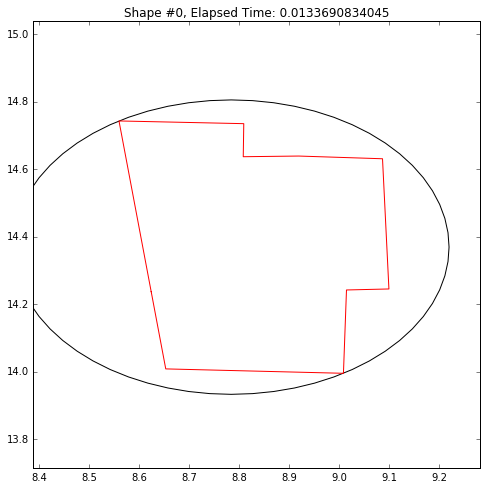

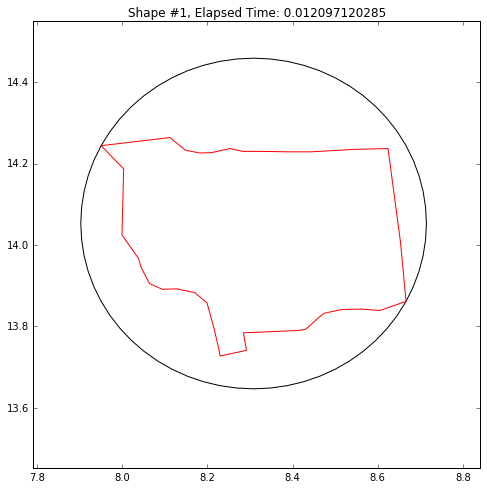

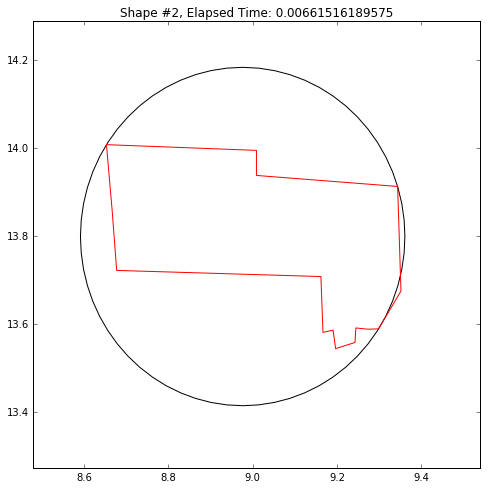

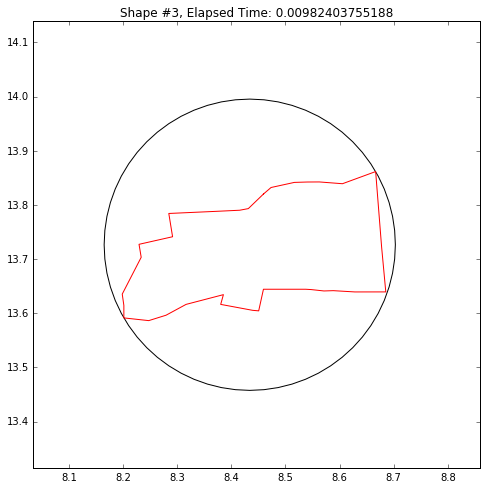

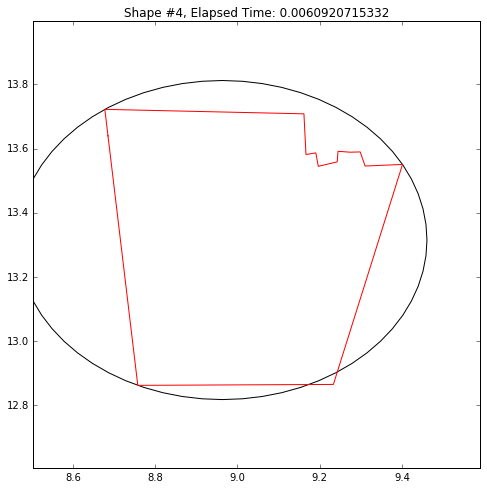

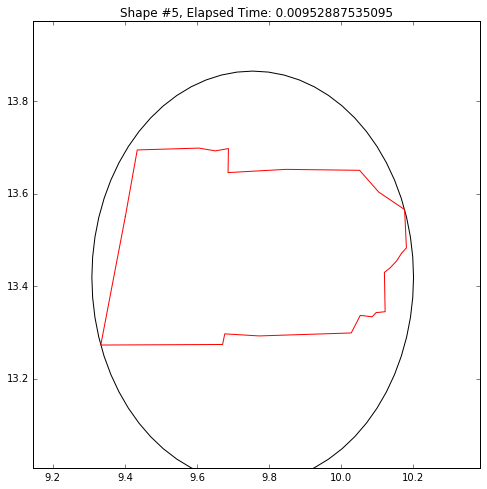

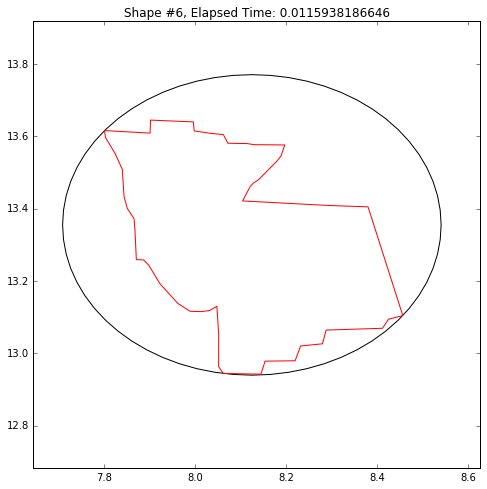

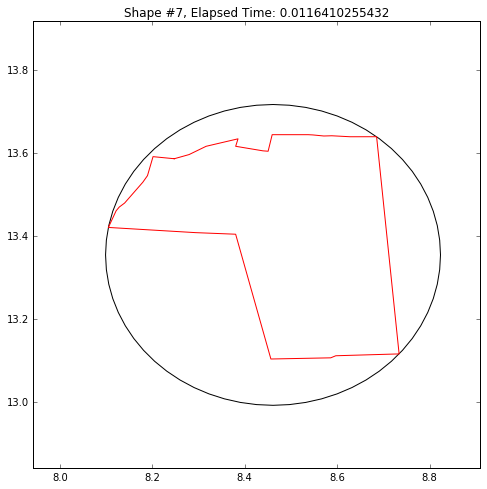

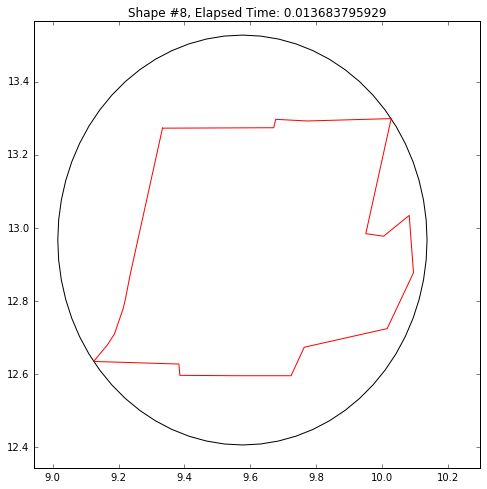

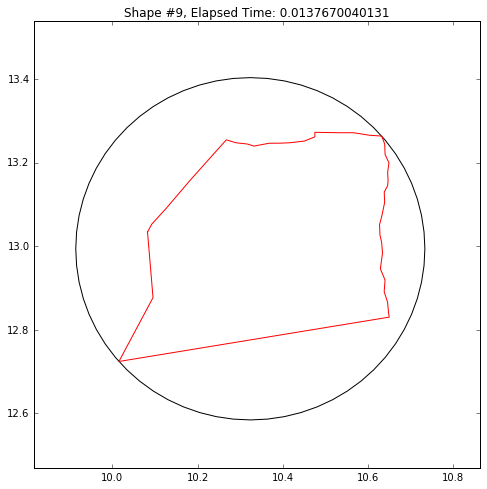

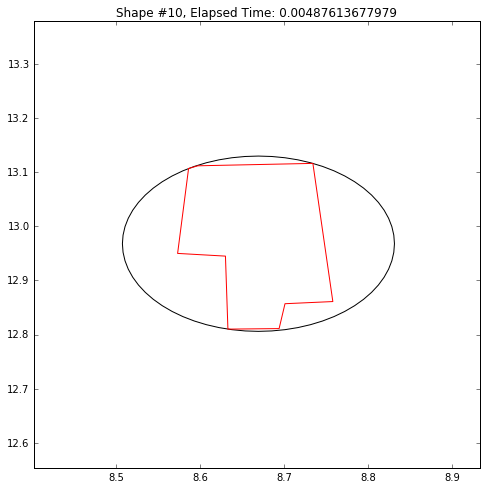

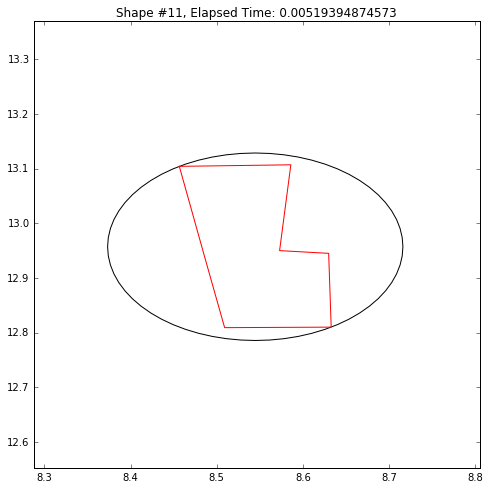

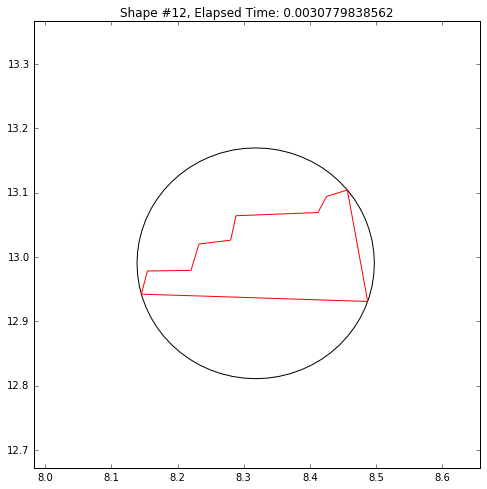

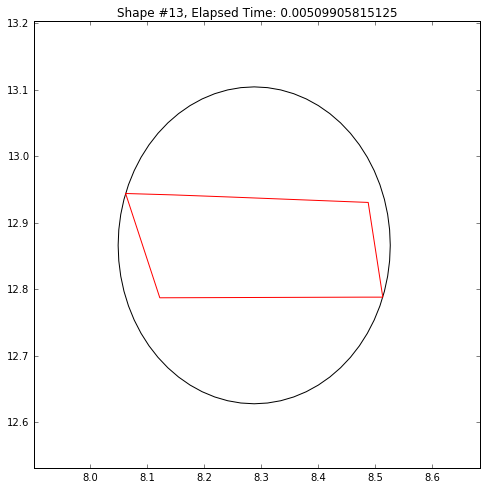

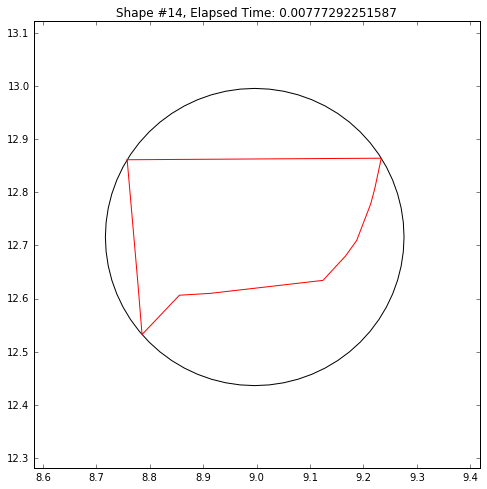

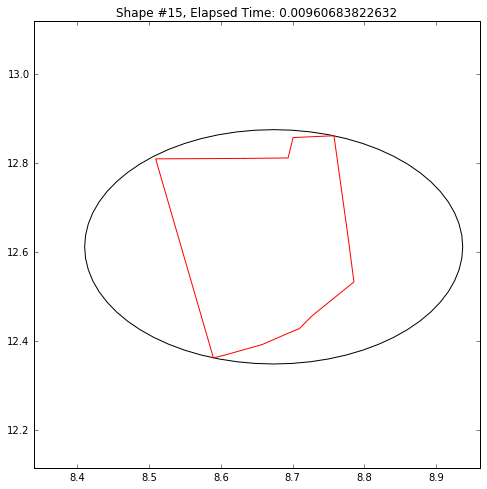

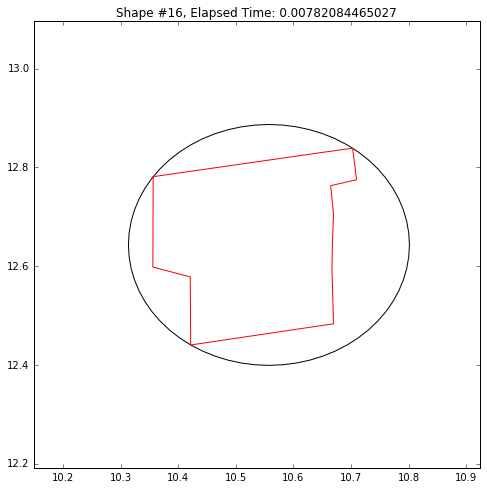

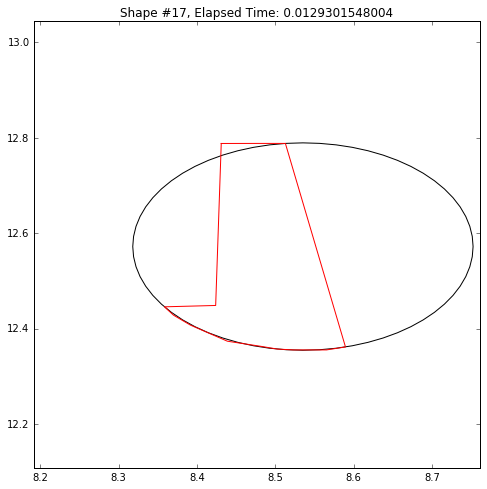

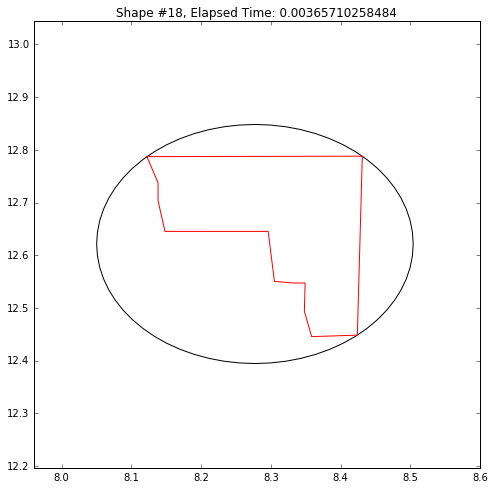

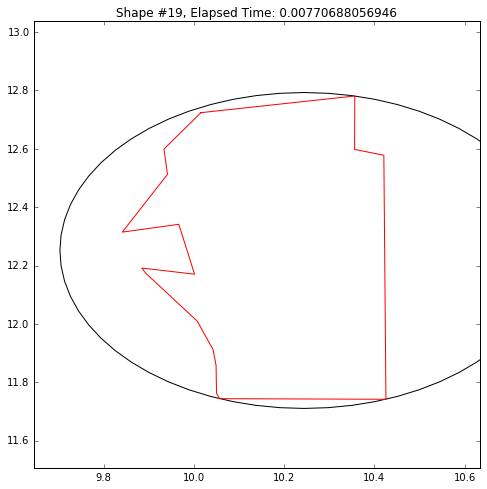

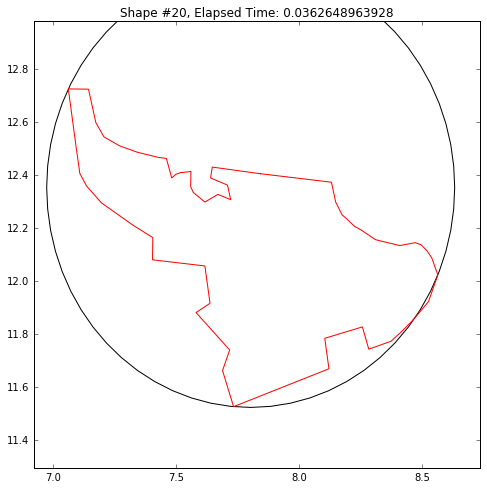

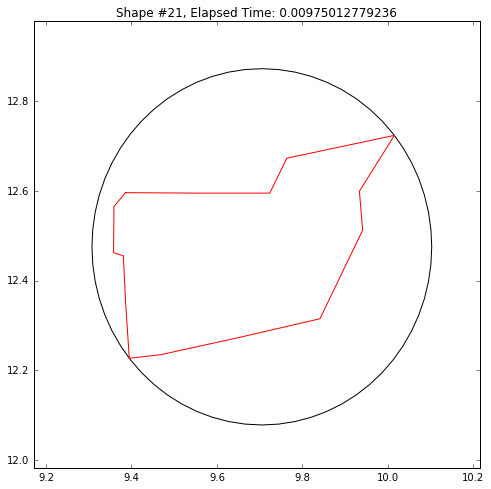

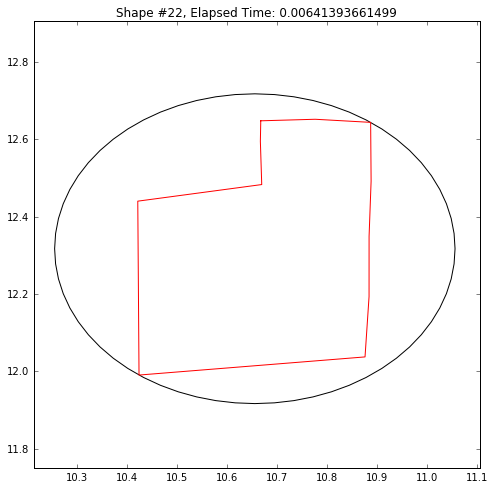

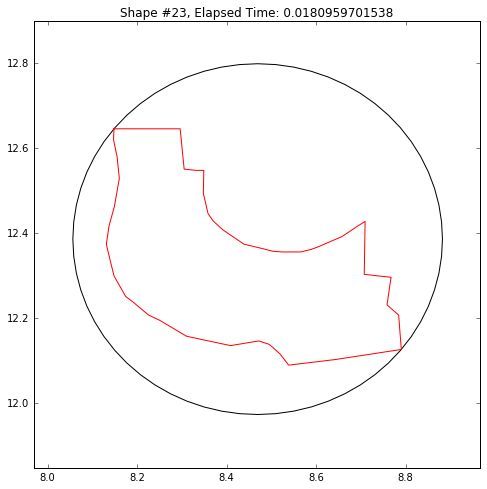

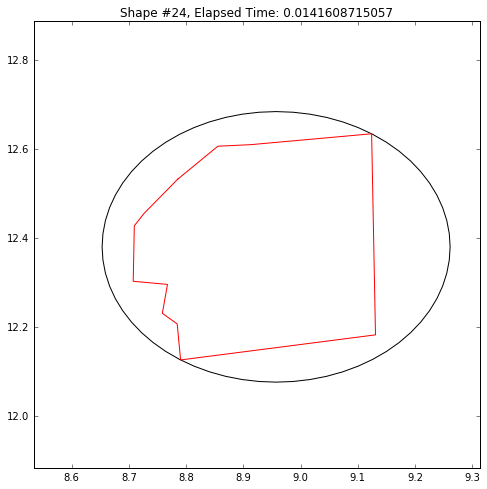

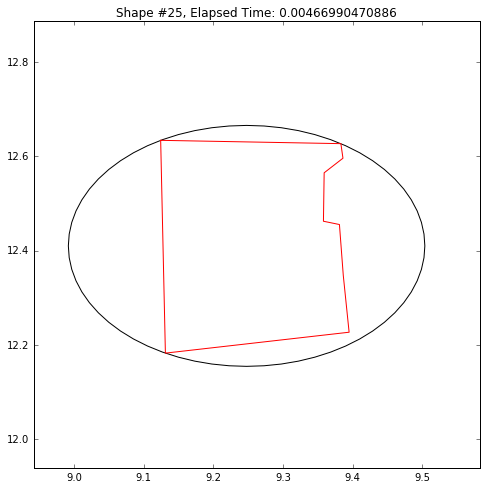

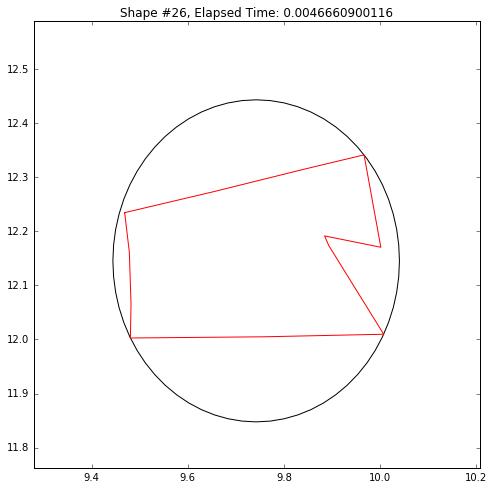

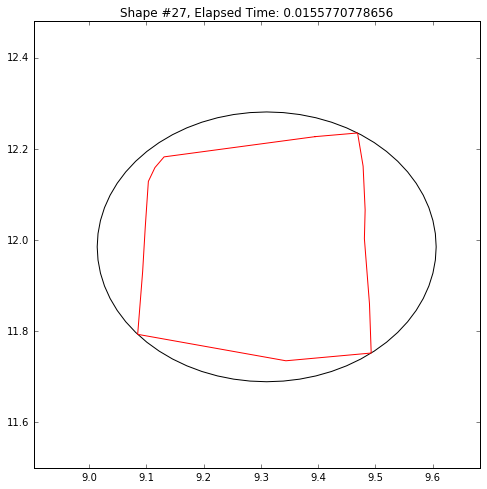

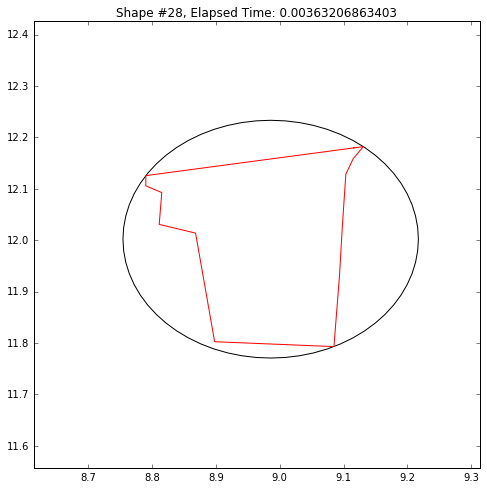

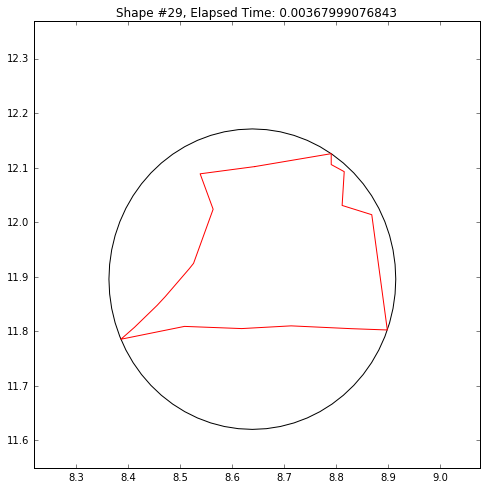

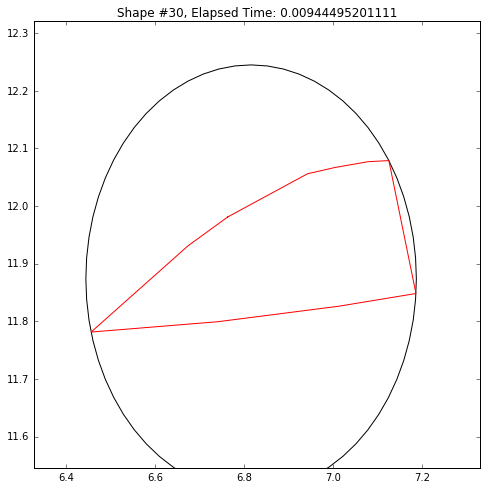

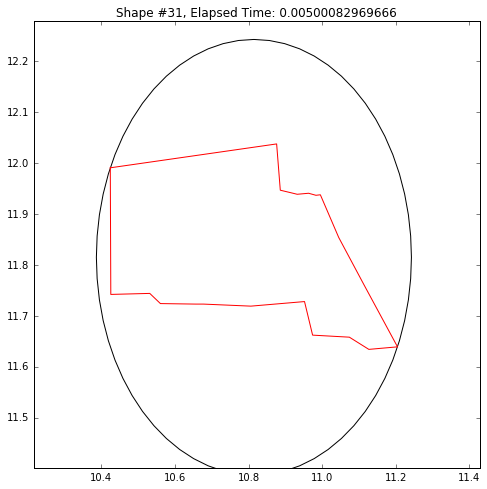

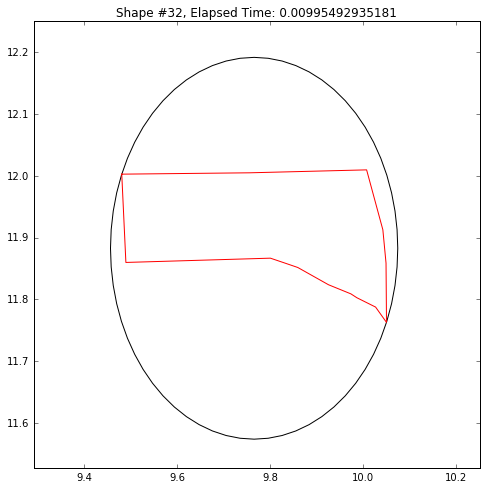

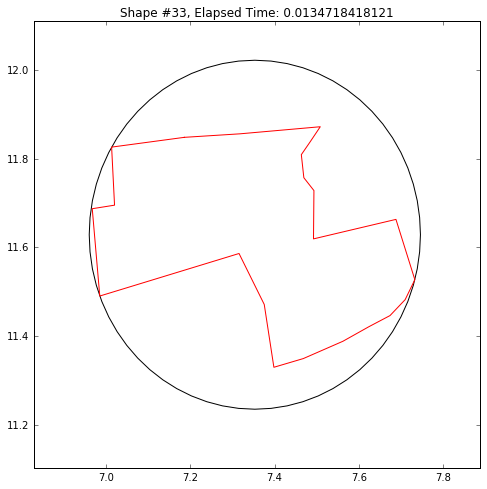

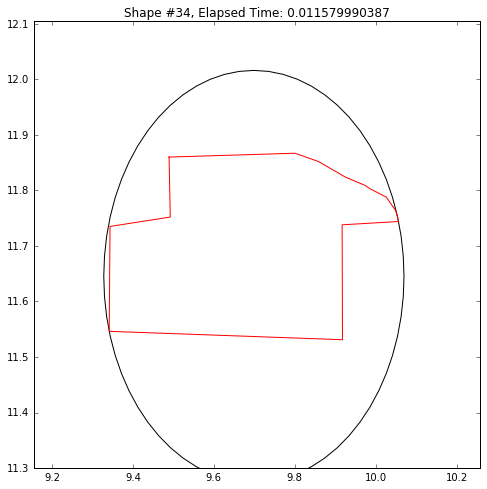

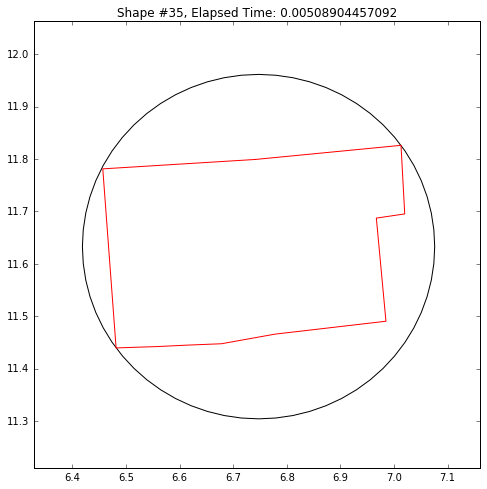

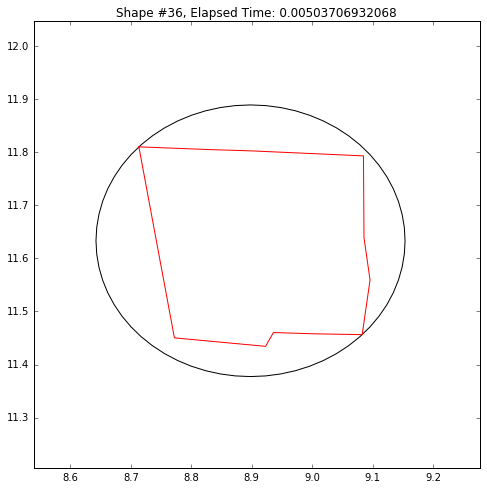

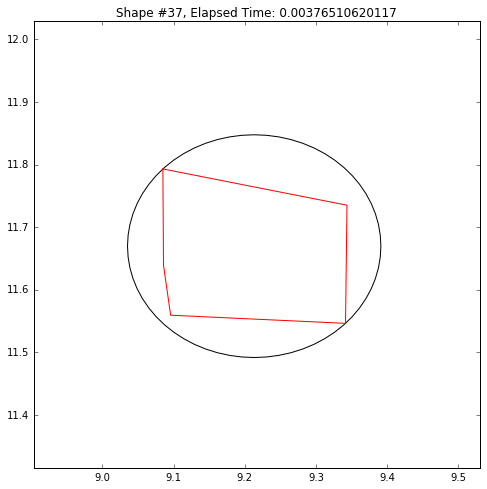

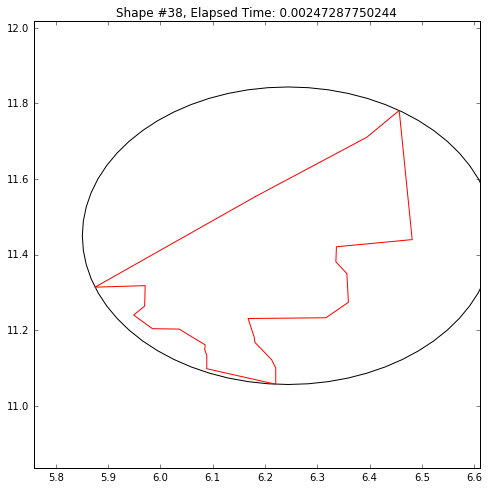

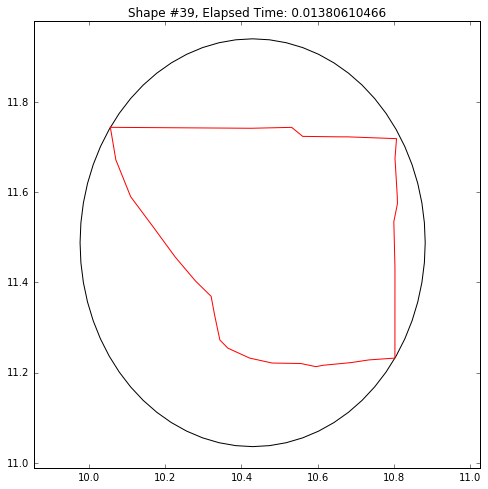

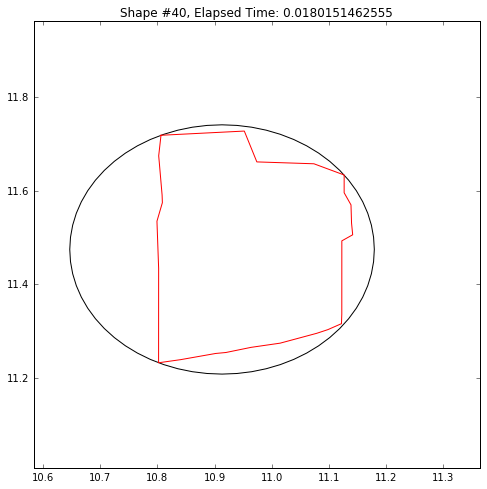

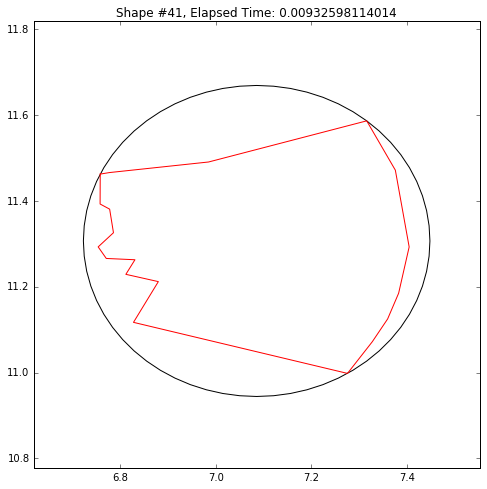

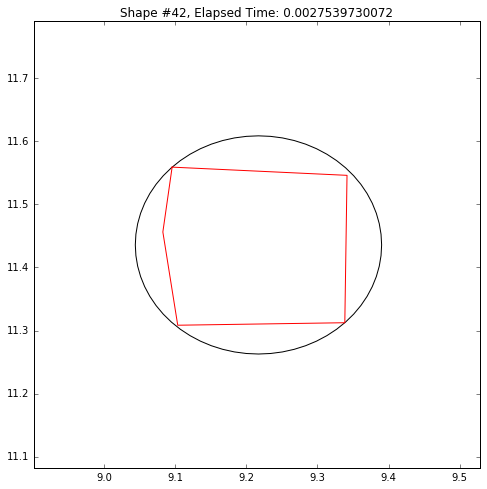

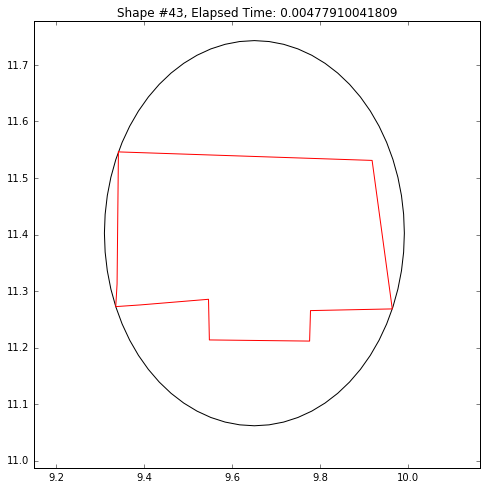

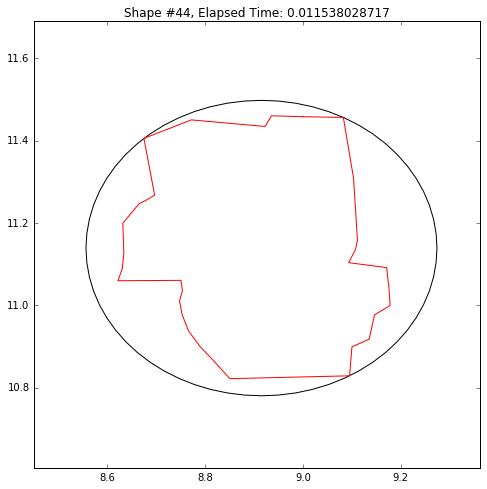

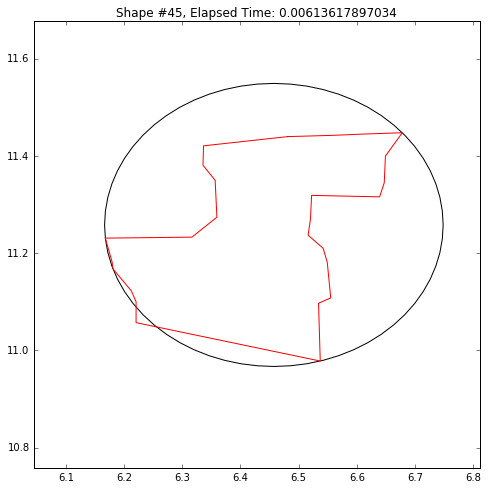

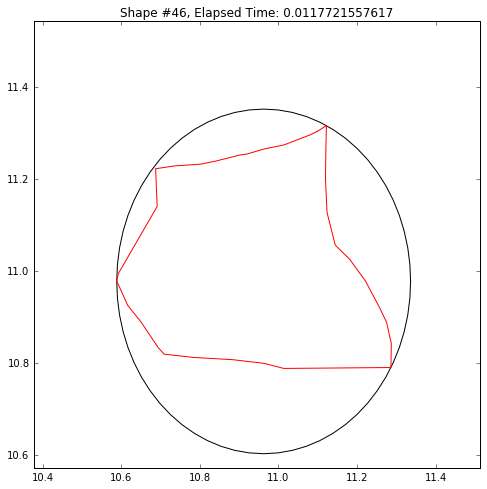

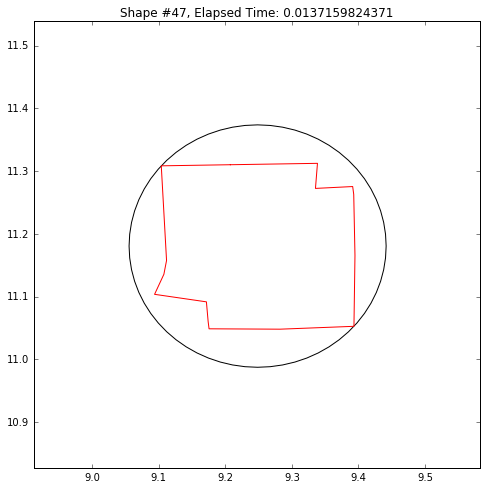

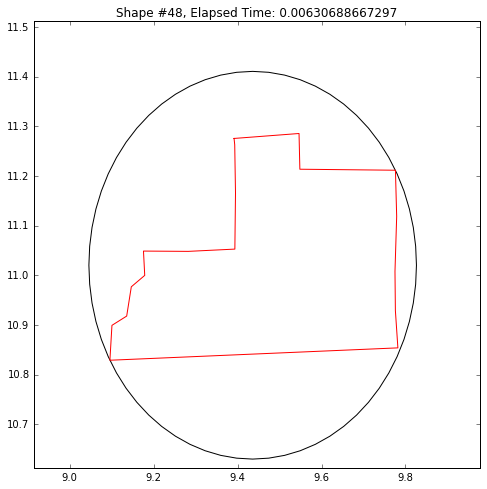

In [19]:
demo_mbc(chains)

Seems as if we're there, in a large part. Now, only shapes 2, 17, 20, and 45 are failing. 

In [20]:
bads = [2, 4, 17, 20, 45]

In [21]:
current = bads.pop()
print(current)

45


In [118]:
removed = []
i = 0

In [119]:
POINTS = [point for part in data[current].parts for point in part]

In [120]:
pset = [point for part in data[current].parts for point in part[:-1]]

In [121]:
pset = [pset[j] for j in com.mbc.ConvexHull(pset).vertices]

In [122]:
len(pset)

8

In [123]:
parray = com.np.array(pset)

In [124]:
parray.min(0)

array([  6.16758585,  10.9780302 ])

#### repeat from here

In [141]:
angles = [com.mbc._angle(*com.mbc._neighb(p,pset)) for p in pset]
circles = [com.mbc._circle(*com.mbc._neighb(p,pset)) for p in pset]
radii = [c[0] for c in circles]
lexord = com.mbc.np.lexsort((radii, angles))
lexmax = lexord[-1]

In [142]:
print(com.np.array((radii, angles)).T[lexord])

[[ 0.29106033  0.87752398]
 [ 0.30120011  1.61821422]
 [ 0.30256593  1.67698829]
 [ 0.26095851  2.11045882]]


In [143]:
if not angles[lexmax] <= com.mbc.PI/2.:
    print('Failure!')
    print("""Angle: {a} (threshold is {pi2})
Center: {c}
Radius: {r}
Remaining: {rem}""".format(a=angles[lexmax], 
                      c=circles[lexmax][-1],
                      r=radii[lexmax], 
                      pi2 = com.mbc.PI /2., 
                      rem = len(pset)))
    removed.append((lexmax, pset.pop(lexmax)))
    i+=1

Failure!
Angle: 2.1104588234 (threshold is 1.57079632679)
Center: (6.428069255711238, 11.21511056663095)
Radius: 0.260958505235
Remaining: 4


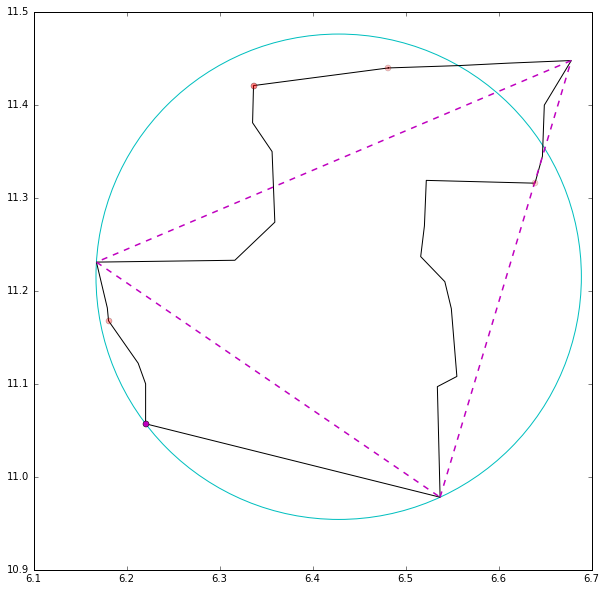

In [144]:
fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,1,1)
plt.plot([p[0] for p in POINTS], [p[1] for p in POINTS], 'k', linewidth=1)
plt.plot([p[0] for p in pset] + [pset[0][0]], [p[1] for p in pset] + [pset[0][1]], 'm--', linewidth=1.5)
plt.plot(removed[-1][-1][0], removed[-1][-1][1], 'mo')
for j, (_, (px, py)) in enumerate(removed[:-1]):
    plt.plot(px,py, 'ro', alpha=1./(len(removed)-j))
solution = plt.Circle(circles[lexmax][-1], radius=circles[lexmax][0], 
                      fill=False, ec='c')
ax1.add_patch(solution)
plt.show()

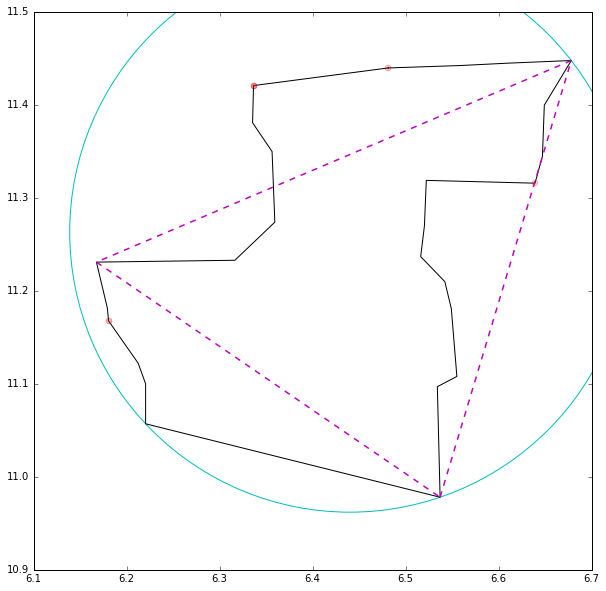

In [146]:
fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(1,1,1)
plt.plot([p[0] for p in POINTS], [p[1] for p in POINTS], 'k', linewidth=1)
plt.plot([p[0] for p in pset] + [pset[0][0]], [p[1] for p in pset] + [pset[0][1]], 'm--', linewidth=1.5)
#plt.plot(removed[-1][-1][0], removed[-1][-1][1], 'mo')
for j, (_, (px, py)) in enumerate(removed[:-1]):
    plt.plot(px,py, 'ro', alpha=1./(len(removed)-j))
solution = plt.Circle(circles[lexord[-3]][1], radius=circles[lexord[-3]][0], 
                      fill=False, ec='c')
ax1.add_patch(solution)
plt.show()

In [154]:
pset + [removed[-1][-1]]

[(6.537120819091797, 10.97803020477295),
 (6.6781768798828125, 11.447600364685059),
 (6.167585849761963, 11.230850219726562),
 (6.220462799072266, 11.057000160217285)]

In [155]:
import scipy.spatial.distance as d

In [157]:
A,B,C,D = pset + [removed[-1][-1]]

In [161]:
com.mbc._angle(A,B,C) + com.mbc._angle(C,D,A)

2.9879827988749281

In [162]:
com.mbc._angle(B,C,D) + com.mbc._angle(D,A,B)

3.2952025083046586